# Preparación de los datos -> Recortar y separar semáforos

In [19]:
import cv2
import numpy as np
import pandas as pd
import os


clips = range(1,14)

# Path guarda separados
path_save = f'/mnt/Datos/Descargas/LISA traffic light dataset/imgSeparadas/trainDAY/'
os.mkdir(path_save)
os.mkdir(path_save+'go')
os.mkdir(path_save+'stop')

for clip in clips:

    # Path imagenes y annotations
    path_ini_img = f'/mnt/Datos/Descargas/LISA traffic light dataset/dayTrain/dayTrain/dayClip{clip}/frames/'
    annotations_path = f'/mnt/Datos/Descargas/LISA traffic light dataset/Annotations/Annotations/dayTrain/dayClip{clip}/frameAnnotationsBOX.csv'
   

    # Annotations con pandas
    annotations = pd.read_csv(annotations_path, sep=';')

    path_imgs = annotations['Filename']

    
    path_imgs = list(map(lambda x : x[12:], path_imgs))

    uly = annotations['Upper left corner Y']
    lry = annotations['Lower right corner Y']

    ulx = annotations['Upper left corner X']
    lrx = annotations['Lower right corner X']


    redgreens = annotations['Annotation tag']


    for i in range(len(annotations)):
        print('.',end='')
        # Lee imagen y recorta
        path_img = path_ini_img+path_imgs[i]
        img = cv2.imread(path_img)
        coordRecorte = (uly[i],lry[i],ulx[i],lrx[i])
        recorte = img[coordRecorte[0]:coordRecorte[1], coordRecorte[2]:coordRecorte[3]]

        # Guarda por separado
        if redgreens[i] == 'go':
            cv2.imwrite(f'{path_save}go/{clip}{i}.jpg',recorte)
        elif redgreens[i] == 'stop':
            cv2.imwrite(f'{path_save}stop/{clip}{i}.jpg',recorte)

    print(f'Conversion finalizada - Clip {clip}. Las imagenes se han separado en 2 tipos.')



........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

# Creacion del modelo en tf.keras

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
batch_size = 512
epochs = 10
IMG_HEIGHT = 100
IMG_WIDTH = 100

In [4]:
train_dir = '/mnt/Datos/Descargas/LISA traffic light dataset/imgSeparadas/trainDAY/'

train_image_generator = ImageDataGenerator() # Generator for our training data
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

validation_dir = '/mnt/Datos/Descargas/LISA traffic light dataset/imgSeparadas/dayseq1/'
validation_image_generator = ImageDataGenerator() # Generator for our validation data
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 27703 images belonging to 2 classes.
Found 7900 images belonging to 2 classes.


## Muestra de imagenes para comprobar que se han cargado bien

In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
sample_training_images, _ = next(train_data_gen)

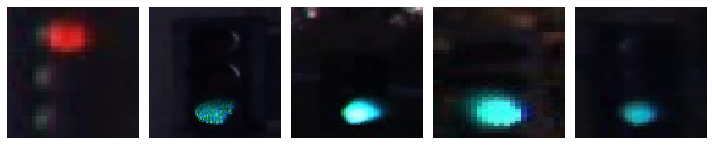

In [7]:
plotImages(sample_training_images[:5])

# Definicion y compilacion del modelo

In [25]:
model = Sequential([
    Conv2D(8, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
    
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
# Configuracion de los logs y de Tensorboard.
log_dir="logs/testnuevo/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [28]:
%load_ext tensorboard
%tensorboard --logdir logs/trainingTrain1

In [30]:
total_train = 27703
total_val = 7900

# Fit del modelo

In [31]:
model.fit_generator(
    train_data_gen,
    steps_per_epoch= 16,#total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=8,#total_val // batch_size,
    callbacks=[tensorboard_callback]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 16 steps, validate for 8 steps
Epoch 1/10
 1/16 [>.............................] - ETA: 2s

ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))

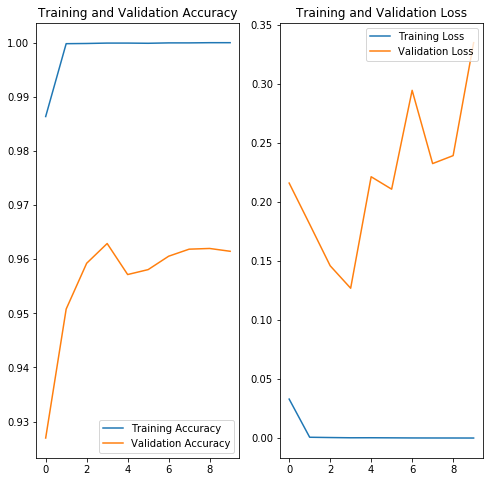

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testeo de predicción

In [15]:
import cv2
test_img = cv2.imread('/mnt/Datos/Descargas/LISA traffic light dataset/imgSeparadas/dayseq2/go/912.jpg')
test_img = cv2.resize(test_img, (IMG_HEIGHT,IMG_WIDTH))

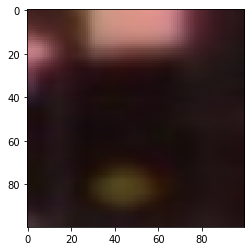

In [16]:
plt.imshow(test_img)

In [17]:
test_img = np.expand_dims(test_img, axis=0)

In [18]:
prediction = model.predict_classes(test_img)

In [19]:
print(prediction)

[[1]]


# Guardado del modelo completo en .h5

In [20]:
model.save('trainingDayCompleto10epochs.h5')